# Analyzing the Impact of Mutations on Amino Acid Biophysical Properties
This segment delves into examining mutation effects, focusing particularly on changes in amino acid biophysical properties.

Amino acids exhibit variations in several attributes like size, hydrophobicity, charge, and polarity. They are also characterized by their acidic or basic nature, and can possess aromatic or aliphatic side chains.

Substituting an amino acid with another of similar properties tends to be less disruptive to protein stability or function than replacing it with an amino acid of markedly different properties. Referenced: Rudnicki, W. R., T. Mroczek, and P. Cudek. "Amino acid properties conserved in molecular evolution." PLoS One 9.6 (2014): e98983.

For our analysis, we selected eight biophysical properties of amino acids, commonly emphasized in scientific literature:

1. **Side Chain Volume**: This refers to the space occupied by an amino acid's side chain within a protein structure. Source: *Krigbaum, W. R., and A. Komoriya. "Local interactions as a structure determinant for protein molecules: II." Biochimica et Biophysica Acta 576.1 (1979): 204-248.*

2. **Hydrophobicity of Side Chain**: Represents the side chain's tendency to repel water. Source: *FAUCHÈRE, J.-L., et al. "Amino acid side chain parameters for correlation studies in biology and pharmacology." International Journal of Peptide and Protein Research 32.4 (1988): 269-278.*

3. **Polarity**: Indicates how electric charges are distributed across the amino acids. Cited from: *Grantham, Richard. "Amino acid difference formula to help explain protein evolution." Science 185.4154 (1974): 862-864.*

4. **Isoelectric Point**: The pH value where the amino acid has a neutral net charge. Referenced: *Zimmerman, J. M., N. Eliezer, and R. Simha. "The characterization of amino acid sequences in proteins by statistical methods." Journal of Theoretical Biology 21.2 (1968): 170-201.*

5. **Accessible Surface Area Loss upon Folding**: Measures the fraction of surface area that becomes concealed in the protein's folded state. Source: *Rose, George D., et al. "Hydrophobicity of amino acid residues in globular proteins." Science 229.4716 (1985): 834-838.*

6. **Interior-Exterior Propensity**: Refers to the preference of amino acids to be inside or on the surface of a protein structure. Cited: *Miller, Susan, et al. "Interior and surface of monomeric proteins." Journal of Molecular Biology 196.3 (1987): 641-656.*

7. **Aromaphilicity**: Describes the tendency for aromatic interactions among amino acids. Referenced: *Hirano, Atsushi, and Tomoshi Kameda. "Aromaphilicity index of amino acids: Molecular dynamics simulations of the protein binding affinity for carbon nanomaterials." ACS Applied Nano Materials 4.3 (2021): 2486-2495.*

8. **Minimum Codon Distance**: Denotes the smallest number of site differences between the most similar codons from different codon families. Source: *Xia, Xuhua, and Xuhua Xia. "Protein substitution model and evolutionary distance." Bioinformatics and the Cell: Modern Computational Approaches in Genomics, Proteomics and Transcriptomics (2018): 315-326.*

Amino acid similarity matrices are known to have a strong correlation with these properties. Referenced: *Tomii, Kentaro, and Minoru Kanehisa. "Analysis of amino acid indices and mutation matrices for sequence comparison and structure prediction of proteins." Protein Engineering, Design and Selection 9.1 (1996): 27-36.*

We employed the most prominent amino acid similarity matrices, standardized them between 0 and 1, and assessed their correlation with the eight chosen biophysical properties. The matrix with the highest correlation for each property was selected. We then used its values to categorize scores (1 to 5), with 1 indicating a minor alteration in biophysical properties and 5 denoting a substantial change.

In [72]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler

# List of standard amino acids
AMINO_ACIDS = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", 
               "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

# Generate all possible pairs of amino acids
pairs = [''.join(pair) for pair in combinations(AMINO_ACIDS, 2)]

# Mapp of amino acids to their respective codons
CODON_TABLE = {'H': ['CAC', 'CAT'], 
 'P': ['CCA', 'CCC', 'CCG', 'CCT'], 
 'F': ['TTC', 'TTT'], 'M': ['ATG'], 
 'V': ['GTA', 'GTC', 'GTG', 'GTT'], 
 'A': ['GCA', 'GCC', 'GCG', 'GCT'], 
 'W': ['TGG'], 'N': ['AAC', 'AAT'], 
 'Y': ['TAC', 'TAT'], 
 'T': ['ACA', 'ACC', 'ACG', 'ACT'], 
 'G': ['GGA', 'GGC', 'GGG', 'GGT'], 
 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'], 
 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'], 
 'Q': ['CAA', 'CAG'], 'D': ['GAC', 'GAT'], 
 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'], 
 'C': ['TGC', 'TGT'], 'E': ['GAA', 'GAG'], 
 'I': ['ATA', 'ATC', 'ATT'], 
 'K': ['AAA', 'AAG']}

# Function to load the substitution matrix and return as a dictionary
def load_substitution_matrix(filename):
    with open(f"data/substitution_matrices/{filename}.json", 'r') as f:
        matrix = json.load(f)
    return {tuple(map(str.strip, key.strip('()').split(','))): float(value)
            for key, value in matrix.items()}

# Function to scale the substitution matrix values and return the scaled dictionary
def scale_substitution_matrix_values(matrix):
    amino_acids = sorted(set(a for pair in matrix for a in pair))
    matrix_array = np.array([[matrix.get((aa1, aa2), matrix.get((aa2, aa1)))
                              for aa2 in amino_acids] for aa1 in amino_acids])
    minMaxScaler = MinMaxScaler()
    scaled_values = minMaxScaler.fit_transform(matrix_array)
    return {(aa1, aa2): scaled_values[i, j] 
            for i, aa1 in enumerate(amino_acids) 
            for j, aa2 in enumerate(amino_acids)}

# Function to adjust the substitution matrix if it is distance based (reverse the scale for matrices like MIYATA, GRANTHAM, and SNEATH)
def adjust_substitution_matrix(substitution_matrix_dictionary, selected_matrix):
    if selected_matrix in ["MIYATA", "GRANTHAM", "SNEATH"]:
        max_value = max(substitution_matrix_dictionary.values())
        adjusted_substitution_matrix_dictionary = {key: max_value - val for key, val in substitution_matrix_dictionary.items()}
        return adjusted_substitution_matrix_dictionary
    else: return substitution_matrix_dictionary

# Function to categorize scores based on substitution matrix values and return the dictionary of scores
def get_scores(changes, scaled_matrix, categorize=True):
    bins = [0.2, 0.4, 0.6, 0.8]
    if categorize: return {entry: (np.digitize((1 if "Ins" in entry or "Del" in entry else 1 - scaled_matrix[(entry[0], entry[-1])]), bins) + 1) for entry in changes}
    else: return {entry: (1 if "Ins" in entry or "Del" in entry else 1 - scaled_matrix[(entry[0], entry[-1])]) for entry in changes}

# Function to plot the mutational impact score distribution
def plot_scores(scores, title):
    sorted_scores = sorted(scores.items(), key=lambda item: item[1])
    plt.figure(figsize=(len(scores)/5, 6))
    for key, value in sorted_scores:
        plt.plot([key, key], [0, value], 'k-', lw=1)
        plt.plot(key, value, 'ro')
    plt.xticks([k for k, v in sorted_scores], rotation=90)
    plt.ylabel('Scores')
    plt.xlabel('Amino acid changes')
    plt.title(title)
    plt.xlim([-1, len(scores)])  
    plt.tight_layout()
    plt.savefig('data/scores.pdf', dpi=300)
    plt.show()

# Function to compute the Hamming distance between two codons
def compute_codon_distance(codon1, codon2):
    return sum(base1 != base2 for base1, base2 in zip(codon1, codon2))

# Function to identify the minimum codon distance between two amino acids
def identify_min_codon_distance(aa1, aa2, aa_to_codons):
    codons_aa1 = aa_to_codons[aa1]
    codons_aa2 = aa_to_codons[aa2]
    return min((compute_codon_distance(codon1, codon2) for codon1 in codons_aa1 for codon2 in codons_aa2), default=0)

# Function to isort the results
def sort_results(results):
    """Sorts results based on the correlation coefficient."""
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    return sorted_results

# Compute the minimum codon distances for each pair of amino acids
minimum_codon_distances = {pair: identify_min_codon_distance(pair[0], pair[1], CODON_TABLE) for pair in pairs}

# Calculate distances between pairs of data points.
def calculate_distances(data, pairs):
    distances = []
    for pair in pairs:
        distance = np.abs(data[pair[0]] - data[pair[1]])
        distances.append(distance)
    return np.array(distances)

# Plot the data with a scatter plot and a best fit line.
def plot_data(ax, x, y, title, xlabel, ylabel, legend, categorized):
    x_array = np.array(x)  
    y_array = np.array(y) 
    correlation_coefficient = np.corrcoef(x_array, y_array)[0, 1]
    slope, intercept = np.polyfit(x_array, y_array, 1)
    best_fit_y = slope * x_array + intercept
    ax.scatter(x_array, y_array, color='black', alpha=0.25, label='Data Points')
    ax.plot(x_array, best_fit_y, color='black', label='Best Fit Line')
    ax.set_title(title.format(correlation_coefficient), fontsize =10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if categorized: ax.set_ylim(0.5, 5.5)
    if legend: ax.legend()
    ax.grid(True)
    
# Plot all the  amino acid properties data
def plot_amino_acid_properties(amino_acid_properties, scores, minimum_codon_distances, pairs, calculate_distances, plot_data):
    # Determine the number of plots and layout
    n_plots = len(amino_acid_properties) + 1
    n_cols = 4
    n_rows = -(-n_plots // n_cols)  
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(24, n_rows * 5))

    # Plot each amino acid property
    for i, (key, value) in enumerate(amino_acid_properties.items()):
        ax = axs[i // n_cols, i % n_cols]
        distances = calculate_distances(value, pairs)
        scores_list = [scores[pair] for pair in pairs]
        plot_data(ax, distances, scores_list, key + ' (r = {:.2f})', 'X', 'Y', False)

    # Plot for MinCodD
    distances = [minimum_codon_distances[pair] for pair in pairs]
    scores_list = [scores[pair] for pair in pairs]
    plot_data(axs[-1, -1], distances, scores_list, "MinCodD (r = {:.2f})", 'X', 'Y', False)
    plt.tight_layout()
    plt.show()

In [73]:
# Load amino acid properties from an Excel file
df = pd.read_excel("data/amino_acid_properties.xlsx")
# Create a dictionary mapping each property to its corresponding values for each amino acid
amino_acid_properties = {col: df.set_index('Amino Acid')[col].to_dict() for col in df.columns if col != 'Amino Acid'}
# Create a DataFrame to represent amino acid changes
amino_acid_changes_df = pd.DataFrame({'Amino_Acid_Changes': pairs})
# Retrieve the names of substitution matrix files from a directory, excluding the file extension
json_files = [file[:-5] for file in os.listdir("data/substitution_matrices") if file.endswith('.json')]

# Analyze each substitution matrix to find the best one considering changes of amino acids biophysical properties
results = []
results_volumes = []
results_polarity = []
results_hydrophobicity = []

for json_file in json_files:
    # Load, scale and adjust the substitution matrix values
    substitution_matrix_dictionary = adjust_substitution_matrix(scale_substitution_matrix_values(load_substitution_matrix(json_file)), json_file)
    
    # Categorize scores for each amino acid change using the scaled substitution matrix
    scores = get_scores(amino_acid_changes_df['Amino_Acid_Changes'], substitution_matrix_dictionary, True)

    # Initialize total sum
    total = 0

    # Loop through each property value in the amino acid properties dictionary
    for key, value in amino_acid_properties.items():
        # Calculate the distances for the current property across all amino acid pairs
        distances = calculate_distances(value, pairs)
        
        # Prepare a list of scores corresponding to each pair
        scores_for_pairs = []
        for pair in pairs:
            scores_for_pairs.append(scores[pair])
        
        # Calculate the correlation coefficient matrix for distances and scores
        correlation_matrix = np.corrcoef(distances, scores_for_pairs)
        
        # Extract the correlation coefficient from the matrix (index [0, 1] or [1, 0])
        correlation_coefficient = correlation_matrix[0, 1]
        
        # Add the correlation coefficient to the total
        total += correlation_coefficient

        if key == "Hydrophobicity of side chain": results_hydrophobicity.append((json_file, correlation_coefficient))
        elif key == "Polarity": results_polarity.append((json_file, correlation_coefficient))
        elif key == "Volume of side chain": results_volumes.append((json_file, correlation_coefficient))

    # Compute the correlation coefficient for minimum codon distances
    min_codon_distances = [minimum_codon_distances[pair] for pair in pairs]
    mincod_correlation = np.corrcoef(min_codon_distances, [scores[pair] for pair in pairs])[0, 1]
    total += mincod_correlation
    results.append((json_file, total))

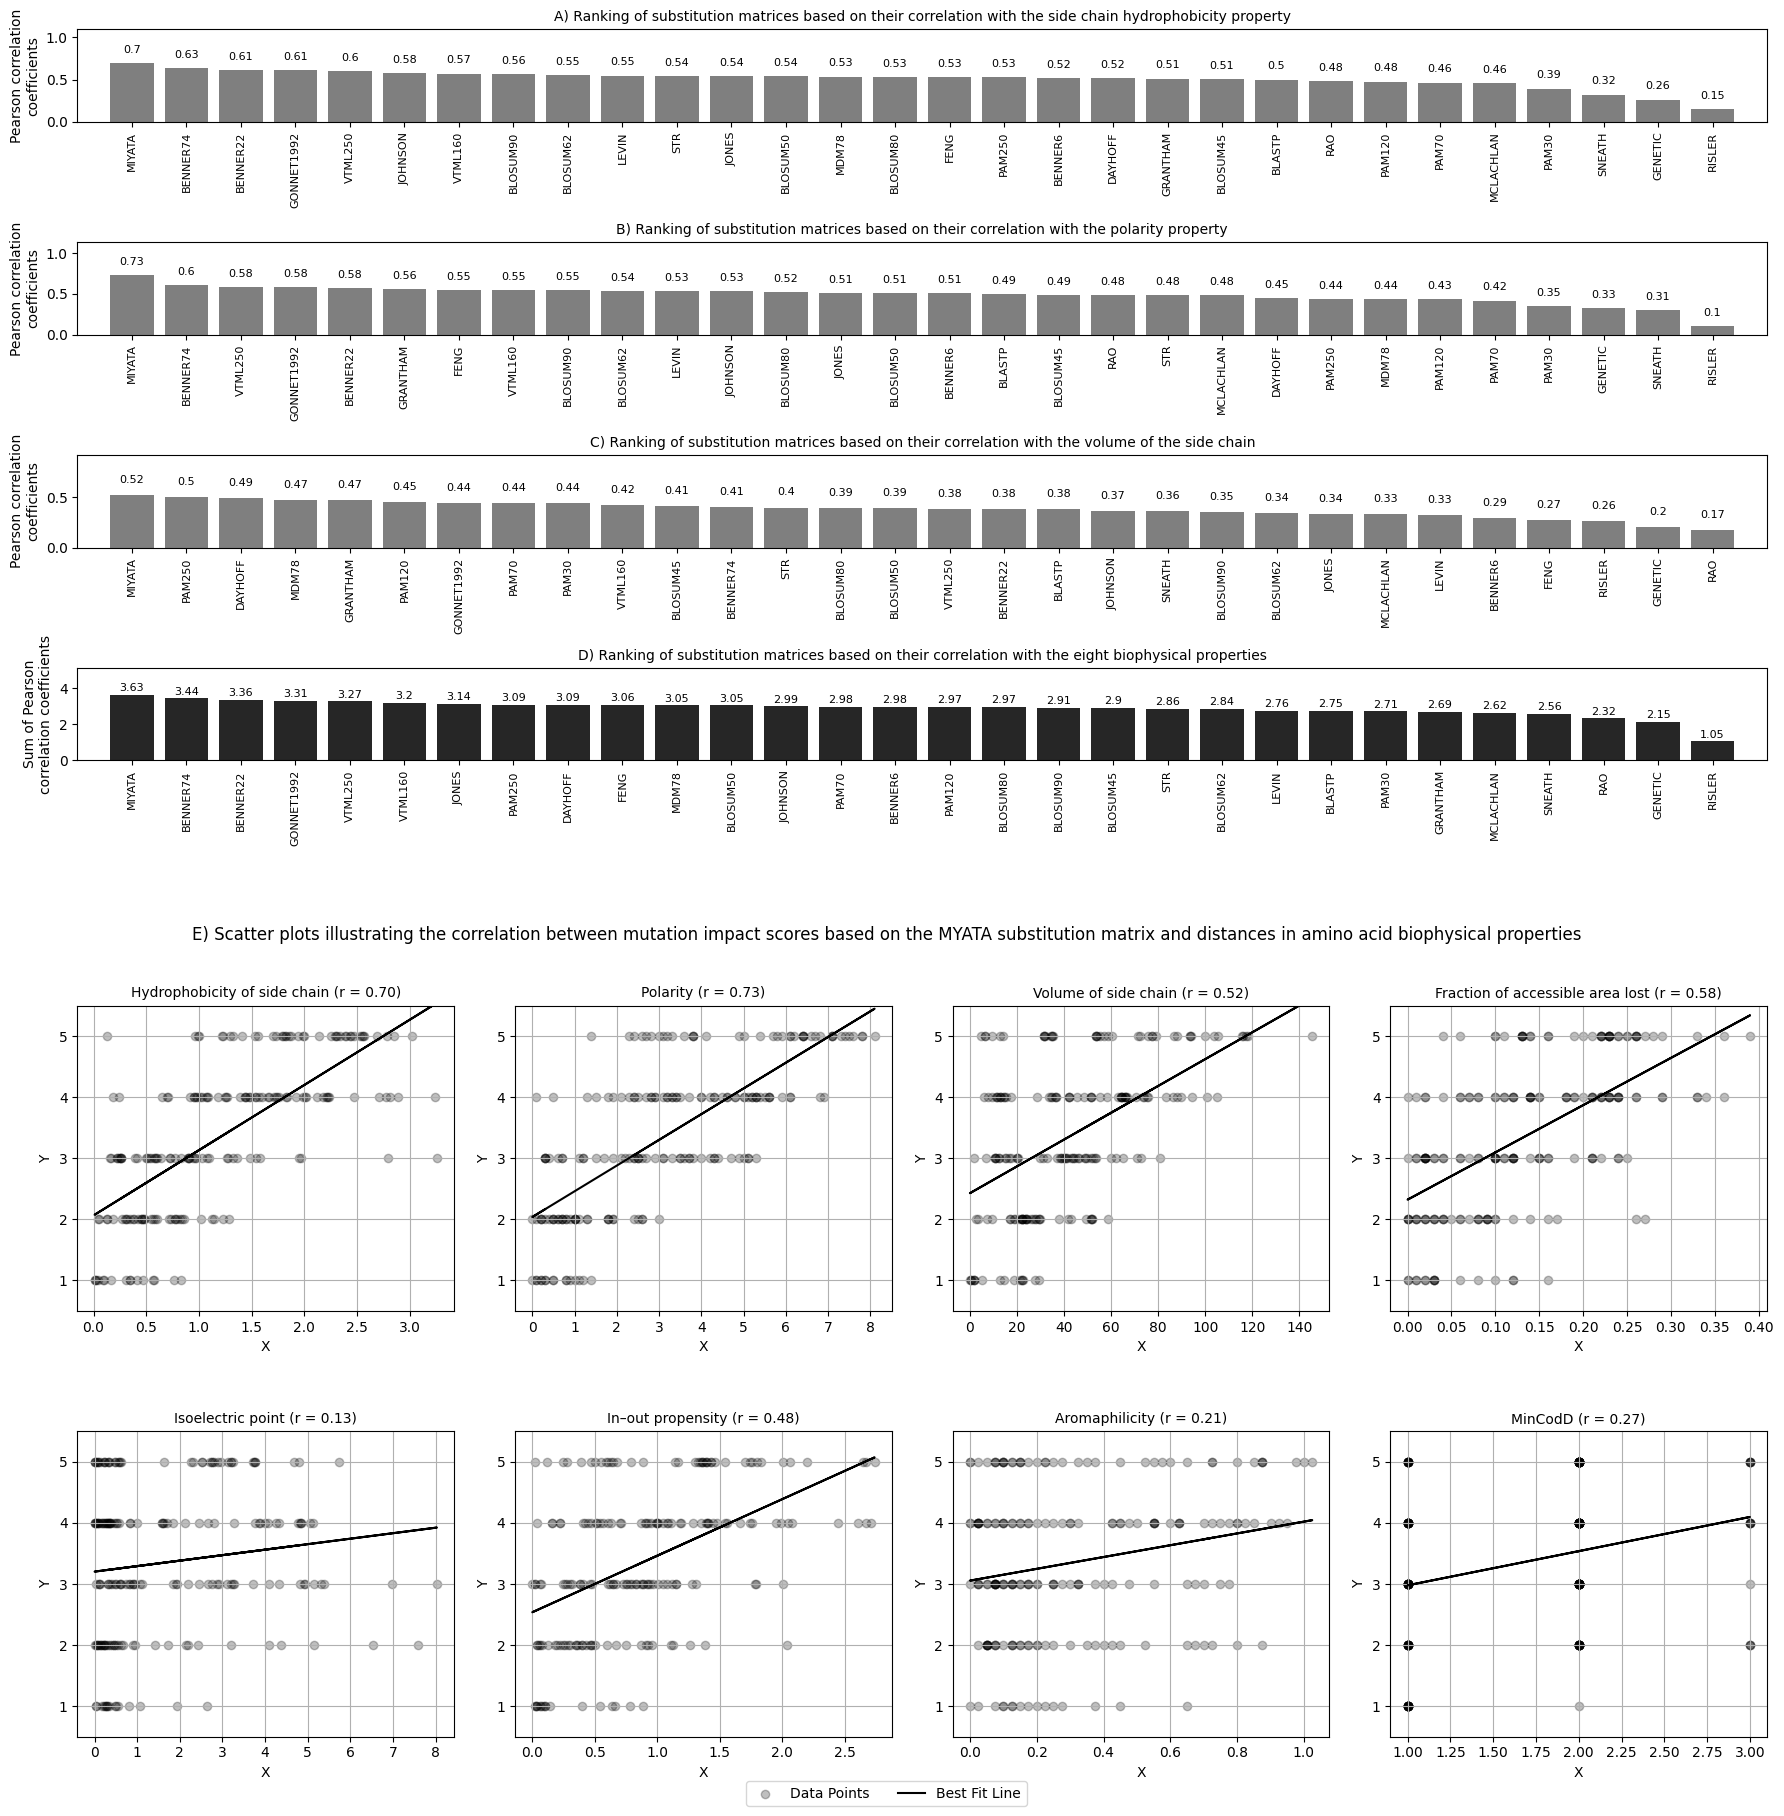

In [74]:
# Sort each results set
sorted_results = sort_results(results)
sorted_hydrophobicity = sort_results(results_hydrophobicity)
sorted_polarity = sort_results(results_polarity)
sorted_volumes = sort_results(results_volumes)
selected_substitution_matrix = sorted_results[0][0]
substitution_matrix_dictionary = adjust_substitution_matrix(scale_substitution_matrix_values(load_substitution_matrix(selected_substitution_matrix)), selected_substitution_matrix)
categorized_scores = get_scores(amino_acid_changes_df['Amino_Acid_Changes'], substitution_matrix_dictionary, True)

# Data and titles for plotting
data = [(sorted_hydrophobicity, 'Hydrophobicity'), (sorted_polarity, 'Polarity'), (sorted_volumes, 'Volumes'), (sorted_results, 'All')]

# Configuration de la grille
fig = plt.figure(figsize=(18, 18))
height_ratios = [1, 1, 1, 1, 0.05, 1, 1, 1, 1]
gs = GridSpec(9, 4, fig, height_ratios=height_ratios)

for idx, (sorted_results, description) in enumerate(data):
    ax = fig.add_subplot(gs[idx, :])
    matrix_names = [result[0] for result in sorted_results]
    correlation_coefficients = [result[1] for result in sorted_results]
    
    if description == "All": 
        bars = ax.bar(matrix_names, correlation_coefficients, color = "black", alpha=0.85)
        ax.set_ylabel('Sum of Pearson\ncorrelation coefficients', fontsize = 10)
        ax.set_title(f'D) Ranking of substitution matrices based on their correlation with the eight biophysical properties', fontsize=10)
    elif description == "Hydrophobicity":
        bars = ax.bar(matrix_names, correlation_coefficients, color = "black", alpha=0.5)
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize = 10)
        ax.set_title(f'A) Ranking of substitution matrices based on their correlation with the side chain hydrophobicity property', fontsize=10)
    elif description == "Polarity":
        bars = ax.bar(matrix_names, correlation_coefficients, color = "black", alpha=0.5)
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize = 10)
        ax.set_title(f'B) Ranking of substitution matrices based on their correlation with the polarity property', fontsize=10)
    elif description == "Volumes":
        bars = ax.bar(matrix_names, correlation_coefficients, color = "black", alpha=0.5)
        ax.set_ylabel('Pearson correlation\ncoefficients', fontsize = 10)
        ax.set_title(f'C) Ranking of substitution matrices based on their correlation with the volume of the side chain', fontsize=10)

    
    # Set ticks before setting tick labels
    ax.set_xticks(range(len(matrix_names)))
    ax.set_xticklabels(matrix_names, rotation=90, fontsize = 8)

    for bar in bars: ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, round(bar.get_height(), 2), ha='center', va='bottom', fontsize=8)
    if description == "All": ax.set_ylim(0, max(correlation_coefficients) + 1.5)
    else: ax.set_ylim(0, max(correlation_coefficients) + 0.4)
    ax.set_xlim(-1, 30)


subplots = [gs[5:7,0], gs[5:7,1], gs[5:7,2], gs[5:7,3], gs[7:9,0], gs[7:9,1], gs[7:9,2], gs[7:9,3]]
#Plot each amino acid property
for i, (key, value) in enumerate(amino_acid_properties.items()):
    ax =  fig.add_subplot(subplots[i])
    distances = calculate_distances(value, pairs)
    scores_list = [categorized_scores[pair] for pair in pairs]
    plot_data(ax, distances, scores_list, key + ' (r = {:.2f})', 'X', 'Y', False, True)

# Plot for MinCodD
ax_min_cod = fig.add_subplot(gs[7:9,3])  # Étendre toutes les colonnes des deux dernières lignes
distances = [minimum_codon_distances[pair] for pair in pairs]
scores_list = [categorized_scores[pair] for pair in pairs]
plot_data(ax_min_cod, distances, scores_list, "MinCodD (r = {:.2f})", 'X', 'Y', False, True)

# Additional title below the subplots
fig.text(0.5, 0.475, 'E) Scatter plots illustrating the correlation between mutation impact scores based on the MYATA substitution matrix and distances in amino acid biophysical properties', ha='center', fontsize=12)
handles, labels = ax.get_legend_handles_labels()  
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01))
plt.tight_layout()
plt.savefig('results_plot.pdf', dpi=300)
plt.show()

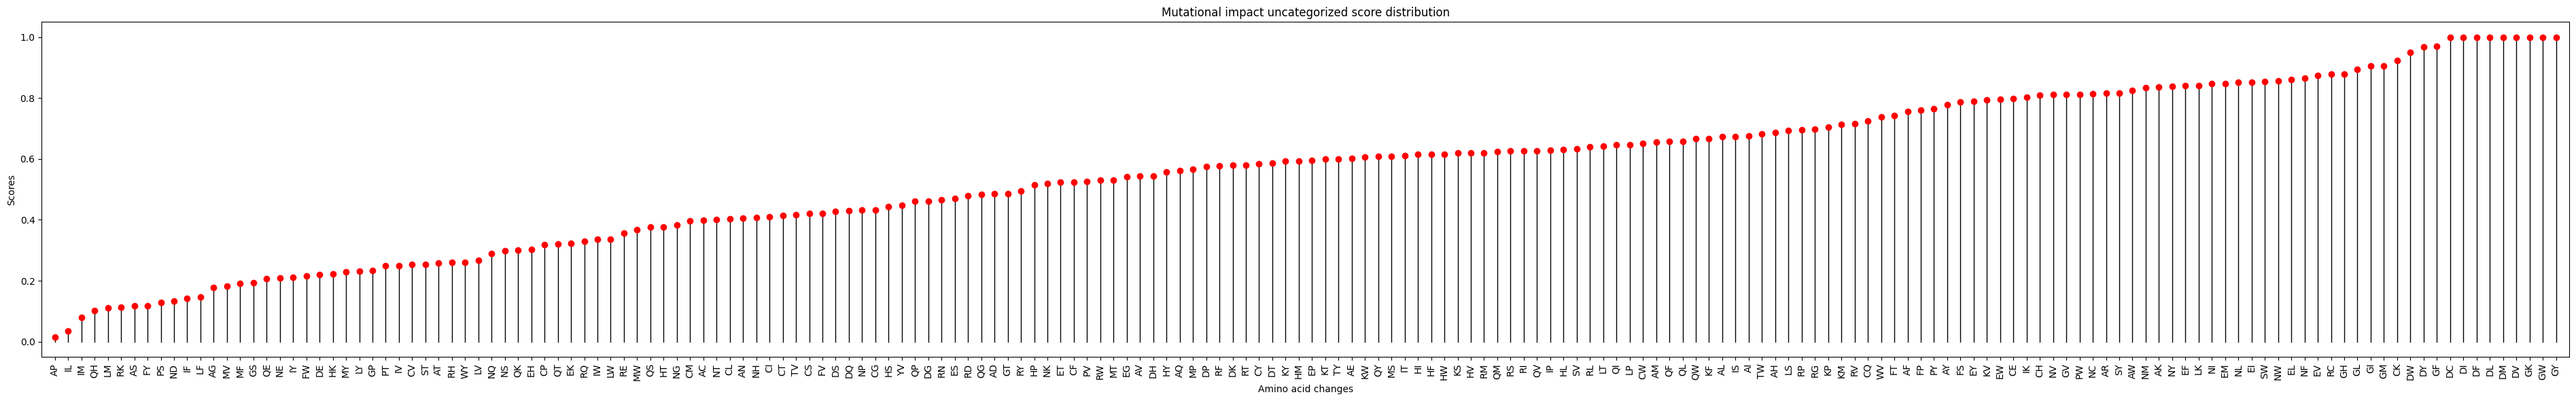

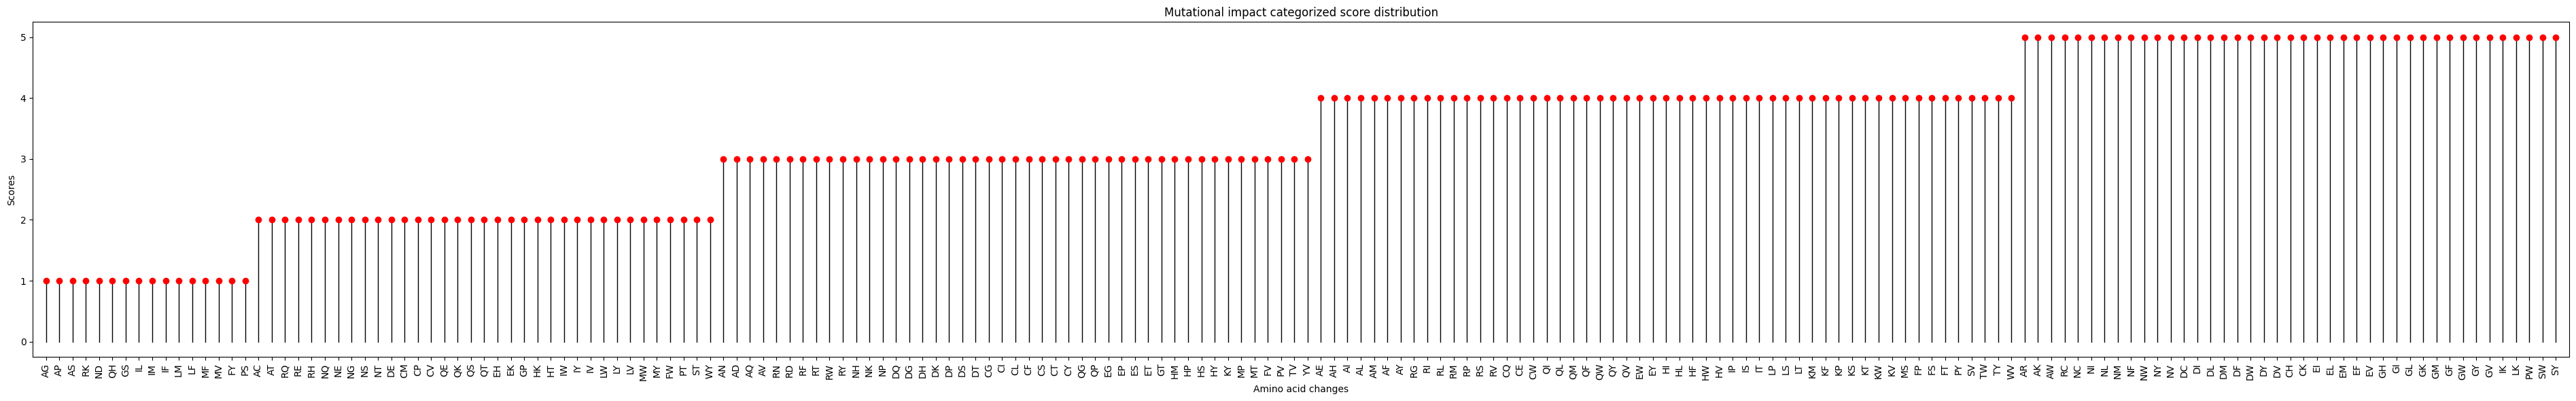

In [78]:
# Usage on all amino acid changes
selected_substitution_matrix = sorted_results[0][0]
substitution_matrix_dictionary = adjust_substitution_matrix(scale_substitution_matrix_values(load_substitution_matrix(selected_substitution_matrix)), selected_substitution_matrix)
uncategorized_scores = get_scores(amino_acid_changes_df['Amino_Acid_Changes'], substitution_matrix_dictionary, False)
categorized_scores = get_scores(amino_acid_changes_df['Amino_Acid_Changes'], substitution_matrix_dictionary, True)
plot_scores(uncategorized_scores, "Mutational impact uncategorized score distribution")
plot_scores(categorized_scores, "Mutational impact categorized score distribution")